## Evaluating regression techniques for speaker characterization - Part II
### Laura Fernández Gallardo

In this notebook, I will evaluate the performance of different regression techniques for characterizing the user, given the data explored in Part I.

The files "SC_ratings_medians.csv" and "SC_ratings_medians.csv" have been generated in this folder.

#### Scope

The goal of this project is to predict speakers' interpersonal traits based on the speech features mentioned above (functionals of F0, loudness, mfccs, jitter, etc.).

I will start by fitting regression models. Let is define the common RMSE (root-mean-square error) and the more robust to outliers MAPE (median absolute percentage) as the metrics for success:

\begin{equation}
RMSE = \sqrt{\frac{\sum_i(y_i-\hat{y}_i)^2}{n}}  
\end{equation}

\begin{equation}
MAPE = median(\left | \frac{y_i-\hat{y}_i}{y_i} \right |)
\end{equation}

where $y_i$ and $\hat{y_i}$ are the observed and the predicted values for the $i^{th}$ data point.


In [1]:
import io
import requests

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

In [5]:
# load speech features from male and from female speakers

path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/"

# load subjective questionnaire items and their translations
url = path + "eGeMAPSv01a_88_malespk.csv"
s = requests.get(url).content
feats_m =pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "eGeMAPSv01a_88_femalespk.csv"
s = requests.get(url).content
feats_f =pd.read_csv(io.StringIO(s.decode('utf-8')))


Pre-processing features:

* join males and females and add 1-hot encoded gender feature
* center and scale speech features of all data

In [6]:
# all features: males and females
feats_m['is_male']=1
feats_f['is_male']=0
feats = pd.concat([feats_m,feats_f], axis = 0)

feats.describe()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0.2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV500.1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,is_male
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,32.178699,0.191036,29.195479,32.497615,35.487213,6.291734,305.132620,465.219884,186.614169,331.245254,...,0.007315,0.101039,2.920460,2.119959,0.209901,0.177489,0.262302,0.409198,-27.948955,0.420000
std,5.302460,0.045772,5.689682,5.648273,5.581904,1.852412,136.022019,260.737297,105.738406,260.995846,...,0.002382,0.029991,0.396761,0.273479,0.036660,0.038392,0.045896,0.058930,0.590704,0.494383
min,20.369190,0.090754,15.787630,19.008480,22.374690,2.906771,31.926970,22.507920,39.196000,19.330250,...,0.000072,0.044194,1.942446,1.301048,0.125636,0.095757,0.167581,0.273608,-29.890070,0.000000
25%,26.869380,0.159612,23.741067,26.610455,30.055792,5.058409,204.830225,263.486675,110.990600,135.118500,...,0.005866,0.080424,2.668827,1.936643,0.186137,0.151392,0.229653,0.367679,-28.263147,0.000000
50%,34.349755,0.185110,31.813500,35.243705,38.093775,6.047605,283.111100,418.261650,161.347300,246.758450,...,0.007465,0.095850,2.862824,2.109847,0.205227,0.174578,0.257518,0.405958,-27.940620,0.000000
75%,36.723568,0.215099,34.248635,37.201692,40.152758,7.295743,391.356575,648.698625,237.425725,467.891975,...,0.008959,0.117125,3.187676,2.281939,0.229600,0.198940,0.293525,0.447432,-27.558625,1.000000
max,40.628860,0.331020,38.364490,41.564300,44.217760,18.519420,693.417700,1316.347000,790.193800,1379.039000,...,0.015888,0.223397,4.529817,3.162737,0.397500,0.346722,0.436176,0.604454,-26.284370,1.000000


In [7]:
# extract speaker ID from sample_heard

feats['speaker_ID'] = feats['sample_heard'].str.slice(1, 4)

In [8]:
feats.head()

,sample_heard,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0.2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,...,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,is_male,speaker_ID
0,m004_linden_stimulus.wav,29.21275,0.228334,24.89525,28.53454,32.79715,7.901901,693.4177,1157.7970,131.25300,...,0.094820,2.751376,1.905717,0.203684,0.205560,0.343333,0.480471,-27.55720,1,004
1,m005_nicosia_stimulus.wav,27.97981,0.162944,24.77392,28.57069,31.23656,6.462639,157.3337,220.8215,75.38364,...,0.060881,2.606429,1.741402,0.277000,0.215467,0.284103,0.532872,-28.37694,1,005
2,m006_rabat_stimulus.wav,31.96671,0.225099,26.73639,31.80232,36.81213,10.075740,311.8069,588.8658,118.47730,...,0.064211,2.687209,1.687007,0.274043,0.259022,0.318409,0.461509,-27.53427,1,006
3,m007_klaksvik_stimulus.wav,24.47457,0.188403,22.10289,24.46268,27.27474,5.171844,211.0591,318.7577,393.00220,...,0.088696,3.559871,1.753247,0.252222,0.211841,0.276896,0.399276,-28.62894,1,007
4,m016_beirut_stimulus.wav,30.19319,0.243157,26.37834,29.65022,33.01906,6.640724,271.1996,315.2922,172.59070,...,0.085694,3.439804,1.822660,0.247027,0.301186,0.323437,0.506289,-28.85239,1,016


In [26]:
X = feats.iloc[:,1:-2]
X_sca = StandardScaler().fit_transform(X)

In [9]:
# Standardize speech features  

scaler = StandardScaler()
scaler.fit(feats.iloc[:,1:-2])
feats_s = scaler.transform(feats.iloc[:,1:-2]) # numpy 300x88

Apply PCA to reduce the number of predictors.

In [13]:
pca = PCA()
pca.fit(feats_s)

In [30]:
feats_pca = pca.transform(feats_s)

In [31]:
feats_pca.shape # np array 300 x n_pca-components

(300, 88)

In [32]:
pca.components_.shape

(88, 88)

In [37]:
np.round(pca.explained_variance_ratio_,2)

array([ 0.21,  0.13,  0.11,  0.06,  0.05,  0.03,  0.03,  0.03,  0.03,
        0.02,  0.02,  0.02,  0.02,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

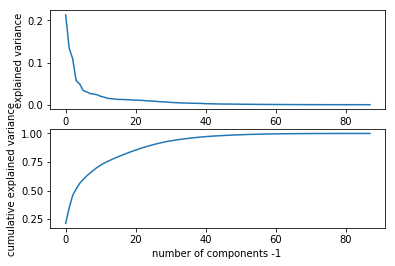

In [51]:
# Explained variance

plt.subplot(2, 1, 1)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components -1 ')
plt.ylabel('explained variance')

plt.subplot(2, 1, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components -1 ')
plt.ylabel('cumulative explained variance')

plt.show()

We will retain the first 5 principal components, which account for 51% of the explained variance.

In [54]:
feats_pca_pd = pd.DataFrame(feats_pca[:,0:5], columns = np.char.mod('%d', np.arange(5)))

Assign instances into 3 classes (1: low, 2: mid, 3: high) for each trait.

(To plot PCA components color-coded by speaker class)

In [56]:
# load ratings (averaged across listeners)
ratings_means = pd.read_csv("SC_ratings_means.csv")

ratings_class = pd.DataFrame(index = ratings_means.index, columns=ratings_means.columns)

# for each trait, assign instances into 3 classes
for i in ratings_means.columns[2:]:
    # percentiles to threshold
    th = np.percentile(ratings_means[i],[33,66])
    ratings_class.loc[ratings_means[i]<th[0],i] = 1 # low class
    ratings_class.loc[ratings_means[i]>=th[0],i] = 2 # mid class
    ratings_class.loc[ratings_means[i]>th[1],i] = 3 # high class
    
ratings_class.iloc[:,0:2] = ratings_means.iloc[:,0:2]     

Let us start by looking at the traits for which listeners had slightly higher agreement: 

* _intelligent_
* _ugly_
* _old_
* _modest_
* _incompetent_

In [ ]:
# plot first pca components
plt.scatter(x="0", y="1", data = feats_pca_pd, c=ratings_class['intelligent'])

It looks like the class separation is going to be challenging!

Let us go on with:

Database partitions: consider train/dev partitions and cross-validation.
Test data will be utterances from other dialogues, given the (somewhat strong) assumption that traits stay constant over time.

* Split the available data to find the model and its hyperparameters leading to the best performance 
* Stratified cross-validation for hyperparameter tuning
* Check performance in test


In [61]:
model_family_list=[]
perf_list = []
hp_list = []

for mf in model_family_list:
    
# split data into 80% and 20% subsets
# give subset A to the inner hyperparameter tuner,
# save subset B for meta-evaluation
A, B = train_test_split(data, 0.8)

# further split A into training and validation sets
C, D = train_test_split(A, 0.8)

# generate_hp_candidates should be a function that knows
# how to generate candidate hyperparameter settings
# for any given model family
hp_settings_list = generate_hp_candidates(mf)

# run hyperparameter tuner to find best hyperparameters
best_hp, best_m = hyperparameter_tuner(C, D,
hp_settings_list)
result = evaluate(best_m, B)
perf_list.append(result)
hp_list.append(best_hp)

# end of inner hyperparameter tuning loop for a single
# model family
# find best model family (max_index is a helper function
# that finds the index of the maximum element in a list)
best_mf = model_family_list[max_index(perf_list)]
best_hp = hp_list[max_index(perf_list)]

# train a model from the best model family using all of
# the data
model = train_mf_model(best_mf, best_hp, data)

(300, 5)